In [ ]:
# Lightweight SNR–error comparison (load UNet, train CAE/DnCNN)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Import model builders from package
from models import build_unet_multitask, build_unet_restoration, build_cae_multitask, build_dncnn_multitask, build_cae_restoration, build_dncnn_restoration

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


2025-10-16 10:40:25.627693: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 10:40:25.878734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-16 10:40:25.878770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-16 10:40:25.921184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-16 10:40:25.997325: I tensorflow/core/platform/cpu_feature_guar

TensorFlow: 2.15.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-10-16 10:40:28.339268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 10:40:28.476727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 10:40:28.476774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# 시각화/평가 유틸을 상단에 배치해 순차 실행 가능하게 구성
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# 공통 스타일 (상단에서도 1회 설정)
mpl.rcParams.update({
    'figure.dpi': 110,
    'savefig.dpi': 150,
    'axes.grid': False,
    'grid.linestyle': ':',
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})
try:
    from matplotlib import font_manager
    preferred = ['NanumGothic', 'Malgun Gothic', 'AppleGothic', 'Noto Sans CJK KR']
    available = {f.name for f in font_manager.fontManager.ttflist}
    for fname in preferred:
        if fname in available:
            mpl.rc('font', family=fname)
            break
    mpl.rcParams['axes.unicode_minus'] = False
except Exception:
    pass

# 조건형/단일입력 모델 모두 대응하는 error 평가 함수

def eval_model_ser_over_snrs(model, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            try:
                _, logits_b = model.predict([noisy_z_b, cond_b], verbose=0)
            except Exception:
                rec_b, logits_b = model.predict(noisy_z_b, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results

# SNR-error 플롯 (교차점 표시/입력 검증/레이아웃 포함)

def plot_snr_error(models_error_dict, title='SNR vs error', threshold=0.10):
    if not isinstance(models_error_dict, dict) or len(models_error_dict) == 0:
        raise ValueError('models_error_dict must be a non-empty dict: {name: {snr: ser}}')
    plt.figure(figsize=(7,5))
    colors = plt.cm.tab10.colors
    for idx, (name, error_map) in enumerate(models_error_dict.items()):
        if not error_map:
            continue
        snrs = np.array(sorted(error_map.keys()))
        errors = np.array([error_map[s] for s in snrs])
        plt.plot(snrs, errors, marker='o', label=name, color=colors[idx % len(colors)])
        mask = (errors <= threshold).astype(int)
        idxs = np.where(np.diff(mask) != 0)[0]
        if idxs.size > 0:
            i = idxs[0]
            x0,x1 = snrs[i], snrs[i+1]; y0,y1 = errors[i], errors[i+1]
            if y1 != y0:
                x_cross = x0 + (threshold - y0) * (x1 - x0) / (y1 - y0)
                plt.scatter([x_cross],[threshold], marker='x', s=80, color=colors[idx % len(colors)])
                plt.text(x_cross, min(1.0, threshold+0.03), f"{name}: {x_cross:.1f} dB", ha='center', fontsize=9)
    plt.axhline(threshold, color='gray', ls='--', lw=1, label=f'error={threshold:.2f}')
    # xlim은 데이터 범위 기준으로 자동 설정
    try:
        x_min = min(k for _, m in models_error_dict.items() for k in m.keys())
        x_max = max(k for _, m in models_error_dict.items() for k in m.keys())
        plt.xlim(x_min, x_max)
    except Exception:
        pass
    plt.ylim(0,1)
    plt.xlabel('SNR (dB)')
    plt.ylabel('error')
    plt.title(title)
    plt.grid(ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

print('Plot utils ready (style + evaluators + plotting)')


Plot utils ready (style + evaluators + plotting)


In [3]:
# Data: CIFAR-10 and z-score helpers
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')/255.0; y_train = y_train.flatten()
x_test  = x_test.astype('float32')/255.0;  y_test  = y_test.flatten()

MEAN = tf.constant(np.mean(x_train, axis=(0,1,2)), dtype=tf.float32)
STD  = tf.constant(np.std(x_train,  axis=(0,1,2)) + 1e-6, dtype=tf.float32)

def to_zscore(x):
    return (x - MEAN) / STD

def from_zscore(z):
    return z * STD + MEAN

cifar10_class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('Data ready:', x_train.shape, x_test.shape)


2025-10-16 10:40:29.349534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 10:40:29.349599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 10:40:29.349615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 10:40:29.540488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16 10:40:29.540542: I external/local_xla/xla/stream_executor

Data ready: (50000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
# Noise: fixed SNR generators (Gaussian/S&P/Burst)

def gaussian_snr_to_cond_vector(snr_db) -> tf.Tensor:
    # Fully TF-native: accept tensor or float
    snr_db = tf.cast(snr_db, tf.float32)
    log10_sigma = -snr_db / 20.0
    c = tf.clip_by_value(log10_sigma - 0.5, 0.0, 1.0)
    return tf.stack([tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), c])


def add_gaussian_noise_fixed_snr(clean_img_01: tf.Tensor, snr_db):
    img_z = to_zscore(clean_img_01)
    snr_db = tf.cast(snr_db, tf.float32)
    sigma = tf.pow(10.0, -snr_db/20.0)
    noise = tf.random.normal(tf.shape(img_z), stddev=sigma, dtype=tf.float32)
    noisy_z = img_z + noise
    cond = gaussian_snr_to_cond_vector(snr_db)
    return noisy_z, cond


def snr_scale_noise(clean_z: tf.Tensor, noisy_z: tf.Tensor, target_snr_db: tf.Tensor):
    noise = noisy_z - clean_z
    px = tf.reduce_mean(tf.square(clean_z))
    pn = tf.reduce_mean(tf.square(noise)) + 1e-12
    r = tf.pow(10.0, target_snr_db/10.0)
    pn_target = px / r
    k = tf.sqrt(tf.maximum(pn_target / pn, 1e-12))
    return clean_z + k*noise


def add_sp_noise_fixed_snr(clean_img_01: tf.Tensor, snr_db: tf.Tensor, amount: float = 0.15):
    img_z = to_zscore(clean_img_01)
    u = tf.random.uniform(tf.shape(img_z))
    salt = tf.cast(u < amount*0.5, tf.float32)
    pepper = tf.cast(u > 1.0 - amount*0.5, tf.float32)
    noisy_z = img_z * (1.0 - salt - pepper) + salt
    noisy_z = snr_scale_noise(img_z, noisy_z, snr_db)
    return noisy_z, tf.convert_to_tensor([0.0,1.0,0.0,amount], dtype=tf.float32)


def add_burst_noise_fixed_snr(clean_img_01: tf.Tensor, snr_db: tf.Tensor, size_factor: float = 0.3, intensity: float = 0.85):
    img_z = to_zscore(clean_img_01)
    h = tf.shape(img_z)[0]; w = tf.shape(img_z)[1]; cch = tf.shape(img_z)[2]
    bh = tf.maximum(1, tf.cast(tf.cast(h, tf.float32)*size_factor, tf.int32))
    bw = tf.maximum(1, tf.cast(tf.cast(w, tf.float32)*size_factor, tf.int32))
    sy = tf.random.uniform([], maxval=tf.maximum(1, h-bh), dtype=tf.int32)
    sx = tf.random.uniform([], maxval=tf.maximum(1, w-bw), dtype=tf.int32)
    patch = tf.random.normal([bh, bw, cch], stddev=intensity)
    noise = tf.pad(patch, [[sy, h-sy-bh], [sx, w-sx-bw], [0,0]])
    mask  = tf.pad(tf.ones([bh, bw, cch]), [[sy, h-sy-bh], [sx, w-sx-bw], [0,0]])
    noisy_z = img_z * (1.0 - mask) + (img_z + noise) * mask
    noisy_z = snr_scale_noise(img_z, noisy_z, snr_db)
    c = tf.clip_by_value(size_factor*intensity, 0.0, 1.0)
    return noisy_z, tf.convert_to_tensor([0.0,0.0,1.0,c], dtype=tf.float32)


def make_fixed_snr_dataset_noise(x, y, snr_db: float, noise_type: str = 'gaussian', batch_size: int = 128):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    def _map_fn(clean_img, label):
        clean_img = tf.cast(clean_img, tf.float32)
        sdb = tf.cast(snr_db, tf.float32)
        if noise_type == 'gaussian': noisy_z, cond = add_gaussian_noise_fixed_snr(clean_img, sdb)
        elif noise_type in ('sp','s&p'): noisy_z, cond = add_sp_noise_fixed_snr(clean_img, sdb)
        elif noise_type == 'burst': noisy_z, cond = add_burst_noise_fixed_snr(clean_img, sdb)
        else: raise ValueError(noise_type)
        clean_z = to_zscore(clean_img)
        return (noisy_z, cond), (clean_z, label)
    return ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [5]:
# Load pretrained UNet (conditional multitask UNet)
unet_path = 'best_cifar10_conditional_model.keras'
unet_model = tf.keras.models.load_model(unet_path)
print('Loaded UNet from:', unet_path)
print('UNet inputs:', [inp.name for inp in unet_model.inputs])


Loaded UNet from: best_cifar10_conditional_model.keras
UNet inputs: ['image_input', 'noise_map_input']


In [6]:
# CAE/DnCNN multitask models
from models import build_cae_multitask, build_dncnn_multitask


def build_cae_multitask(input_shape_img=(32,32,3), input_shape_map=(4,), num_classes=10):
    img_in  = layers.Input(shape=input_shape_img, name='image_input')
    cond_in = layers.Input(shape=input_shape_map, name='noise_map_input')
    x = layers.Conv2D(32,3,padding='same',activation='relu')(img_in)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    s1 = x  # 32x32
    p1 = layers.MaxPooling2D(2)(s1)  # 16x16
    x = layers.Conv2D(64,3,padding='same',activation='relu')(p1)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    s2 = x  # 16x16
    p2 = layers.MaxPooling2D(2)(s2)  # 8x8
    x = layers.Conv2D(128,3,padding='same',activation='relu')(p2)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    feat = layers.GlobalAveragePooling2D()(x)
    feat = layers.Concatenate()([feat, cond_in])
    feat = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(feat)
    feat = layers.Dropout(0.5)(feat)
    cls_out = layers.Dense(num_classes, activation='softmax', name='classification_output')(feat)
    d = layers.Conv2DTranspose(64,2,strides=2,padding='same')(x)  # 16x16
    d = layers.Concatenate()([d, s2])
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2DTranspose(32,2,strides=2,padding='same')(d)  # 32x32
    d = layers.Concatenate()([d, s1])
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    rec = layers.Conv2D(3,1,activation='linear', name='restoration_output')(d)
    return Model(inputs=[img_in, cond_in], outputs=[rec, cls_out], name='CAE_multitask')


def build_dncnn_multitask(input_shape_img=(32,32,3), input_shape_map=(4,), num_classes=10, depth=17, filters=64):
    img_in  = layers.Input(shape=input_shape_img, name='image_input')
    cond_in = layers.Input(shape=input_shape_map, name='noise_map_input')
    x = layers.Conv2D(filters,3,padding='same',activation='relu')(img_in)
    for _ in range(depth-2):
        x = layers.Conv2D(filters,3,padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    res = layers.Conv2D(3,3,padding='same',activation='linear', name='residual_pred')(x)
    rec = layers.Subtract(name='restoration_output')([img_in, res])
    feat = layers.GlobalAveragePooling2D()(x)
    feat = layers.Concatenate()([feat, cond_in])
    feat = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(feat)
    feat = layers.Dropout(0.5)(feat)
    cls_out = layers.Dense(num_classes, activation='softmax', name='classification_output')(feat)
    return Model(inputs=[img_in, cond_in], outputs=[rec, cls_out], name='DnCNN_multitask')

# Learning rate schedule (match UNet): ExponentialDecay per-step
STEPS_PER_EPOCH = int(np.ceil(len(x_train)/128))
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=STEPS_PER_EPOCH,
    decay_rate=0.96,
    staircase=True
)
    
cae_model = build_cae_multitask(num_classes=10)
dncnn_model = build_dncnn_multitask(num_classes=10)

for m in [cae_model, dncnn_model]:
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss={'restoration_output':'mae','classification_output':'sparse_categorical_crossentropy'},
              loss_weights={'restoration_output':0.8,'classification_output':0.2},
              metrics={'classification_output':'accuracy'})

print('CAE/DnCNN ready with LR schedule')



CAE/DnCNN ready with LR schedule


In [7]:
# Mixed-SNR training dataset (Gaussian only by default)
BATCH_SIZE = 128

def gen_mixed_gaussian_sample(clean_img, label):
    clean_img = tf.cast(clean_img, tf.float32)
    snr_db = tf.random.uniform([], -30.0, -10.0)
    noisy_z, cond = add_gaussian_noise_fixed_snr(clean_img, snr_db)
    clean_z = to_zscore(clean_img)
    return (noisy_z, cond), (clean_z, label)

train_ds_mixed = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                  .shuffle(50000)
                  .map(gen_mixed_gaussian_sample, num_parallel_calls=tf.data.AUTOTUNE)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE))

val_ds_mixed = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                .map(gen_mixed_gaussian_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

print('Datasets ready')


Datasets ready


In [8]:
# Mixed-noise training dataset (Gaussian + S&P + Burst)
BATCH_SIZE = 128

def gen_mixed_noise_sample(clean_img, label):
    clean_img = tf.cast(clean_img, tf.float32)
    snr_db = tf.random.uniform([], -30.0, -10.0)
    choice = tf.random.uniform([], 0, 3, dtype=tf.int32)

    def _gauss():
        return add_gaussian_noise_fixed_snr(clean_img, snr_db)

    def _sp():
        amount = tf.random.uniform([], 0.05, 0.25)
        return add_sp_noise_fixed_snr(clean_img, snr_db, amount=amount)

    def _burst():
        size_factor = tf.random.uniform([], 0.15, 0.40)
        intensity   = tf.random.uniform([], 0.60, 1.00)
        return add_burst_noise_fixed_snr(clean_img, snr_db, size_factor=size_factor, intensity=intensity)

    noisy_z, cond = tf.switch_case(choice, branch_fns={
        0: _gauss,
        1: _sp,
        2: _burst,
    })
    clean_z = to_zscore(clean_img)
    return (noisy_z, cond), (clean_z, label)

train_ds_mixed_types = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                        .shuffle(50000)
                        .map(gen_mixed_noise_sample, num_parallel_calls=tf.data.AUTOTUNE)
                        .batch(BATCH_SIZE)
                        .prefetch(tf.data.AUTOTUNE))

val_ds_mixed_types = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                      .map(gen_mixed_noise_sample, num_parallel_calls=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      .prefetch(tf.data.AUTOTUNE))

print('Mixed-noise datasets ready (Gaussian/S&P/Burst)')


Mixed-noise datasets ready (Gaussian/S&P/Burst)


In [9]:
# Baseline UNet (no conditioning) setup: datasets + model + compile
from models import build_unet_multitask

# Unoned datasets: model takes only noisy image z-scores as input
BATCH_SIZE = 128
EPOCHS = 200

def drop_cond_for_uncond(inp, tgt):
    noisy_z, cond = inp
    clean_z, label = tgt
    return noisy_z, (clean_z, label)

train_ds_mixed_uncond = train_ds_mixed_types.map(drop_cond_for_uncond)
val_ds_mixed_uncond   = val_ds_mixed_types.map(drop_cond_for_uncond)

# Build and compile baseline UNet (multitask: restoration + classification)
unet_base = build_unet_multitask(input_shape_img=(32,32,3), num_classes=10, residual=False)
unet_base.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={'restoration_output':'mae','classification_output':'sparse_categorical_crossentropy'},
    loss_weights={'restoration_output':0.8,'classification_output':0.2},
    metrics={'classification_output':'accuracy'}
)

unet_base_ckpt = 'best_unet_baseline.keras'
callbacks_unet_base = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=unet_base_ckpt, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

if os.path.exists(unet_base_ckpt):
    print(f'Loading baseline UNet from {unet_base_ckpt}')
    unet_base = tf.keras.models.load_model(unet_base_ckpt)
else:
    print('\nTraining baseline UNet (up to 200 epochs, early-stop) ...')
    unet_base.fit(train_ds_mixed_uncond, epochs=EPOCHS, validation_data=val_ds_mixed_uncond, callbacks=callbacks_unet_base, verbose=1)
    print('Saved best baseline UNet to', unet_base_ckpt)


Loading baseline UNet from best_unet_baseline.keras


In [10]:
# error evaluator for baseline UNet (single input)

def eval_unet_base_ser_over_snrs(model, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            rec_b, logits_b = model.predict(noisy_z_b, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results


In [11]:
# Evaluate and plot: UNet (MTL) vs Baseline UNet (no cond)
try:
    if 'snr_grid' not in globals():
        snr_grid = list(range(-30, -9, 2))
    if 'unet_ser' not in globals():
        unet_ser = eval_model_ser_over_snrs(unet_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    unet_base_ser = eval_unet_base_ser_over_snrs(unet_base, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    compare_map = {
        'UNet (MTL)': unet_ser,
        'UNet (Base)': unet_base_ser,
    }
    plot_snr_error(compare_map, title='Gaussian: SNR vs error (UNet MTL vs UNet Base)')
except Exception as e:
    print('Baseline UNet evaluation skipped due to error:', e)


2025-10-16 10:40:38.708412: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905


In [12]:
# error evaluators and plotting (standardized)

# 공통 스타일/폰트 설정은 별도 셀에서 수행

def eval_model_ser_over_snrs(model, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            # 모델 입출력 보장: 조건형 모델([noisy, cond])만 받음
            try:
                _, logits_b = model.predict([noisy_z_b, cond_b], verbose=0)
            except Exception:
                # 단일 입력 모델을 넣었을 경우 대비
                rec_b, logits_b = model.predict(noisy_z_b, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results


def plot_snr_error(models_error_dict, title='SNR vs error', threshold=0.10):
    # 입력 검증 및 정렬
    if not isinstance(models_error_dict, dict) or len(models_error_dict) == 0:
        raise ValueError('models_error_dict must be a non-empty dict: {name: {snr: ser}}')
    plt.figure(figsize=(7,5))
    colors = plt.cm.tab10.colors
    for idx, (name, error_map) in enumerate(models_error_dict.items()):
        if not error_map:
            continue
        snrs = np.array(sorted(error_map.keys()))
        errors = np.array([error_map[s] for s in snrs])
        plt.plot(snrs, errors, marker='o', label=name, color=colors[idx % len(colors)])
        # 10% 교차점 보조표시
        mask = (errors <= threshold).astype(int)
        idxs = np.where(np.diff(mask) != 0)[0]
        if idxs.size > 0:
            i = idxs[0]
            x0,x1 = snrs[i], snrs[i+1]; y0,y1 = errors[i], errors[i+1]
            if y1 != y0:
                x_cross = x0 + (threshold - y0) * (x1 - x0) / (y1 - y0)
                plt.scatter([x_cross],[threshold], marker='x', s=80, color=colors[idx % len(colors)])
                plt.text(x_cross, min(1.0, threshold+0.03), f"{name}: {x_cross:.1f} dB", ha='center', fontsize=9)
    plt.axhline(threshold, color='gray', ls='--', lw=1, label=f'error={threshold:.2f}')
    plt.ylim(0,1)
    plt.xlim(min(min(k for _, m in models_error_dict.items() for k in m.keys()), -30),
             max(max(k for _, m in models_error_dict.items() for k in m.keys()), 0))
    plt.xlabel('SNR (dB)')
    plt.ylabel('error')
    plt.title(title)
    plt.grid(ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
# Evaluate UNet error first (Gaussian)
snr_grid = list(range(-30, -9, 2))
unet_ser = eval_model_ser_over_snrs(unet_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
print('UNet error computed for', len(snr_grid), 'SNR points')


UNet error computed for 11 SNR points


Loading CAE weights from best_cae_multitask.keras


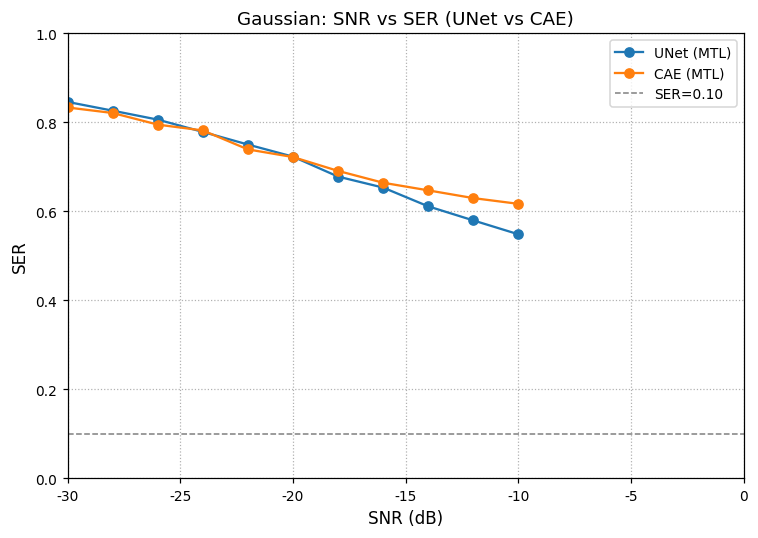

In [14]:
# Train/Load CAE MTL only, then evaluate error (Gaussian)
EPOCHS = 200
cae_ckpt = 'best_cae_multitask.keras'


callbacks_cae = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=cae_ckpt, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

if os.path.exists(cae_ckpt):
    print(f'Loading CAE weights from {cae_ckpt}')
    cae_model = tf.keras.models.load_model(cae_ckpt)
else:
    print('\nTraining CAE (up to 200 epochs, early-stop) ...')
    cae_model.fit(train_ds_mixed_types, epochs=EPOCHS, validation_data=val_ds_mixed_types, callbacks=callbacks_cae, verbose=1)

cae_ser = eval_model_ser_over_snrs(cae_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

models_map = {'UNet (MTL)': unet_ser, 'CAE (MTL)': cae_ser}
plot_snr_error(models_map, title='Gaussian: SNR vs error (UNet vs CAE)')

In [15]:
# Fixed classifier (clean CIFAR-10) with load-if-exists

def build_fixed_classifier(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name='FixedClassifier')

clf_ckpt = 'best_fixed_classifier.keras'
if os.path.exists(clf_ckpt):
    print(f'Loading fixed classifier from {clf_ckpt}')
    fixed_clf = tf.keras.models.load_model(clf_ckpt)
else:
    fixed_clf = build_fixed_classifier()
    fixed_clf.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    clf_callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ModelCheckpoint(filepath=clf_ckpt, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
    ]
    print('\nTraining fixed classifier on clean CIFAR-10 ...')
    fixed_clf.fit(x_train, y_train, validation_data=(x_test, y_test),
                  epochs=50, batch_size=256, callbacks=clf_callbacks, verbose=1)
    print('Saved best fixed classifier to', clf_ckpt)



Loading fixed classifier from best_fixed_classifier.keras


In [16]:
# CAE (current default is No-Skip): build/load/train + error eval + plot include
from models import build_cae_multitask

cae_ns_ckpt = 'best_cae_multitask_noskip.keras'

# 재사용: train_ds_mixed / val_ds_mixed, lr_schedule 동일
try:
    if os.path.exists(cae_ns_ckpt):
        print(f'Loading CAE (NoSkip default) from {cae_ns_ckpt}')
        cae_ns = tf.keras.models.load_model(cae_ns_ckpt)
    else:
        cae_ns = build_cae_multitask(input_shape_img=(32,32,3), num_classes=10)
        cae_ns.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                       loss={'restoration_output':'mae','classification_output':'sparse_categorical_crossentropy'},
                       loss_weights={'restoration_output':0.8,'classification_output':0.2},
                       metrics={'classification_output':'accuracy'})
        callbacks_cae_ns = [
            EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
            ModelCheckpoint(filepath=cae_ns_ckpt, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
        ]
        print('Training CAE (NoSkip default) ...')
        cae_ns.fit(train_ds_mixed_types, epochs=200, validation_data=val_ds_mixed_types, callbacks=callbacks_cae_ns, verbose=1)
        print('Saved best CAE (NoSkip default) to', cae_ns_ckpt)
        cae_ns = tf.keras.models.load_model(cae_ns_ckpt)
except Exception as e:
    print('CAE (NoSkip default) train/load skipped due to error:', e)

# error (Gaussian)
try:
    if 'snr_grid' not in globals():
        snr_grid = list(range(-30, -9, 2))
    cae_noskip_ser = eval_model_ser_over_snrs(cae_ns, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    # 비교 플롯에 추가
    models_map = {'UNet (MTL)': unet_ser}
    if 'cae_ser' in globals():
        models_map['CAE (MTL)'] = cae_ser
    models_map['CAE (NoSkip)'] = cae_noskip_ser
    if 'dncnn_ser' in globals():
        models_map['DnCNN (MTL)'] = dncnn_ser
    plot_snr_error(models_map, title='Gaussian: SNR vs error (UNet/CAE/NoSkip/DnCNN)')
except Exception as e:
    print('CAE (NoSkip default) evaluation skipped due to error:', e)



Training CAE (NoSkip default) ...
Epoch 1/200
CAE (NoSkip default) train/load skipped due to error: in user code:

    File "/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.wit

In [17]:
# 공통 시각화 스타일 설정 (한글/폰트/rcParams)
import matplotlib as mpl
import matplotlib.pyplot as plt

# Backend는 노트북 기본 사용; 경고 완화와 일관 스타일 설정
mpl.rcParams.update({
    'figure.dpi': 110,
    'savefig.dpi': 150,
    'axes.grid': False,
    'grid.linestyle': ':',
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

# 한글 폰트 설정: 시스템에 나눔/맑은 고딕 등 있을 경우 우선 적용, 없으면 기본 유지
try:
    from matplotlib import font_manager
    preferred = ['NanumGothic', 'Malgun Gothic', 'AppleGothic', 'Noto Sans CJK KR']
    available = {f.name for f in font_manager.fontManager.ttflist}
    for fname in preferred:
        if fname in available:
            mpl.rc('font', family=fname)
            break
    mpl.rcParams['axes.unicode_minus'] = False
except Exception:
    pass

print('Plot style configured')


Plot style configured


In [18]:
# Add UNet restoration-only model into pipeline comparison
from models import build_unet_restoration

unet_rest_ckpt = 'best_unet_restoration.keras'
unet_rest = build_unet_restoration(input_shape=(32,32,3), base_filters=32, depth=3, residual=True)
unet_rest.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')

rest_train = train_ds_mixed_types.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))
rest_val   = val_ds_mixed_types.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))

if os.path.exists(unet_rest_ckpt):
    print(f'Loading UNet restoration from {unet_rest_ckpt}')
    unet_rest = tf.keras.models.load_model(unet_rest_ckpt)
else:
    print('\nTraining UNet restoration ...')
    unet_rest.fit(rest_train, validation_data=rest_val, epochs=100,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                             ModelCheckpoint(filepath=unet_rest_ckpt, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)],
                  verbose=1)



Loading UNet restoration from best_unet_restoration.keras


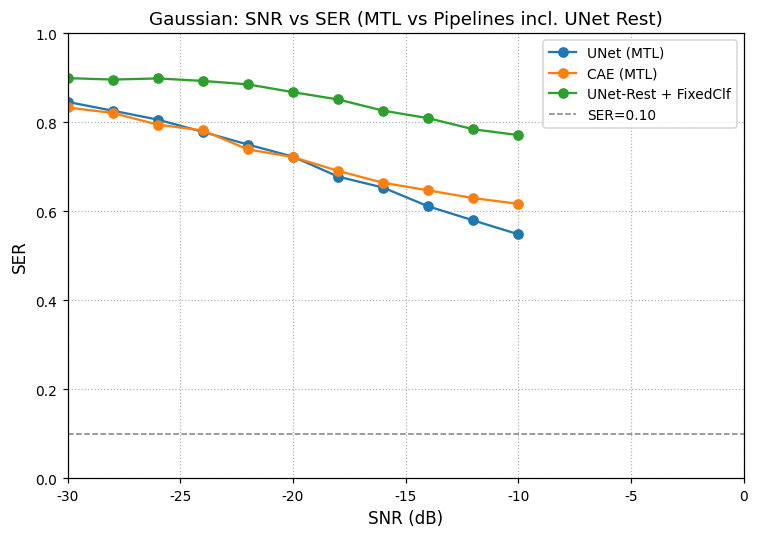

In [19]:
rest_train = train_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))
rest_val   = val_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))

# 2) 파이프라인 error 평가 함수 (복원기 + 고정 분류기)
def eval_pipeline_ser_over_snrs(classifier, restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            if restorer is None:
                restored = from_zscore(noisy_z_b)
            else:
                restored = restorer.predict(from_zscore(noisy_z_b), verbose=0)
            logits_b = classifier.predict(restored, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results

# Evaluate pipeline again with UNet restoration (guarded)
if 'snr_grid' not in globals():
    snr_grid = list(range(-30, -9, 2))
try:
    unet_pipe_ser = eval_pipeline_ser_over_snrs(fixed_clf, unet_rest, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
except Exception as e:
    print('UNet restoration pipeline evaluation skipped:', e)
    unet_pipe_ser = None

# 안전한 결합 플롯 구성: 존재하는 결과만 포함
models_map = {}
if 'unet_ser' in globals():
    models_map['UNet (MTL)'] = unet_ser
if 'cae_ser' in globals():
    models_map['CAE (MTL)'] = cae_ser
if 'dncnn_ser' in globals():
    models_map['DnCNN (MTL)'] = dncnn_ser
if 'no_rest_ser' in globals():
    models_map['No-Rest + FixedClf'] = no_rest_ser
if 'cae_pipe_ser' in globals():
    models_map['CAE-Rest + FixedClf'] = cae_pipe_ser
if 'dn_pipe_ser' in globals():
    models_map['DnCNN-Rest + FixedClf'] = dn_pipe_ser
if 'unet_pipe_ser' in globals() and unet_pipe_ser is not None:
    models_map['UNet-Rest + FixedClf'] = unet_pipe_ser

if models_map:
    plot_snr_error(models_map, title='Gaussian: SNR vs error (MTL vs Pipelines incl. UNet Rest)')
else:
    print('No models to plot yet.')


In [20]:
# Basic restoration-only CAE/DnCNN (no conditioning, no classifier head)

def build_cae_restoration(input_shape=(32,32,3)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inp)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    s1 = x
    p1 = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(p1)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    s2 = x
    p2 = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(p2)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    d = layers.Conv2DTranspose(64,2,strides=2,padding='same')(x)
    d = layers.Concatenate()([d, s2])
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2DTranspose(32,2,strides=2,padding='same')(d)
    d = layers.Concatenate()([d, s1])
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    out = layers.Conv2D(3,1,activation='linear')(d)
    return Model(inp, out, name='CAE_restoration')


def build_dncnn_restoration(input_shape=(32,32,3), depth=17, filters=64):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters,3,padding='same',activation='relu')(inp)
    for _ in range(depth-2):
        x = layers.Conv2D(filters,3,padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    res = layers.Conv2D(3,3,padding='same',activation='linear')(x)
    out = layers.Subtract()([inp, res])
    return Model(inp, out, name='DnCNN_restoration')

cae_rest_ckpt = 'best_cae_restoration.keras'
dncnn_rest_ckpt = 'best_dncnn_restoration.keras'

cae_rest = build_cae_restoration(); dncnn_rest = build_dncnn_restoration()
for m in [cae_rest, dncnn_rest]:
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')

# Train or load restoration-only models using mixed Gaussian SNR data
rest_train = train_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))
rest_val   = val_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))

rest_callbacks_cae = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                      ModelCheckpoint(filepath=cae_rest_ckpt, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)]
rest_callbacks_dn  = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                      ModelCheckpoint(filepath=dncnn_rest_ckpt, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)]

if os.path.exists(cae_rest_ckpt):
    print(f'Loading CAE restoration from {cae_rest_ckpt}')
    cae_rest = tf.keras.models.load_model(cae_rest_ckpt)
else:
    print('\nTraining CAE restoration ...')
    cae_rest.fit(rest_train, validation_data=rest_val, epochs=100, callbacks=rest_callbacks_cae, verbose=1)

if os.path.exists(dncnn_rest_ckpt):
    print(f'Loading DnCNN restoration from {dncnn_rest_ckpt}')
    dncnn_rest = tf.keras.models.load_model(dncnn_rest_ckpt)
else:
    print('\nTraining DnCNN restoration ...')
    dncnn_rest.fit(rest_train, validation_data=rest_val, epochs=100, callbacks=rest_callbacks_dn, verbose=1)



Loading CAE restoration from best_cae_restoration.keras
Loading DnCNN restoration from best_dncnn_restoration.keras


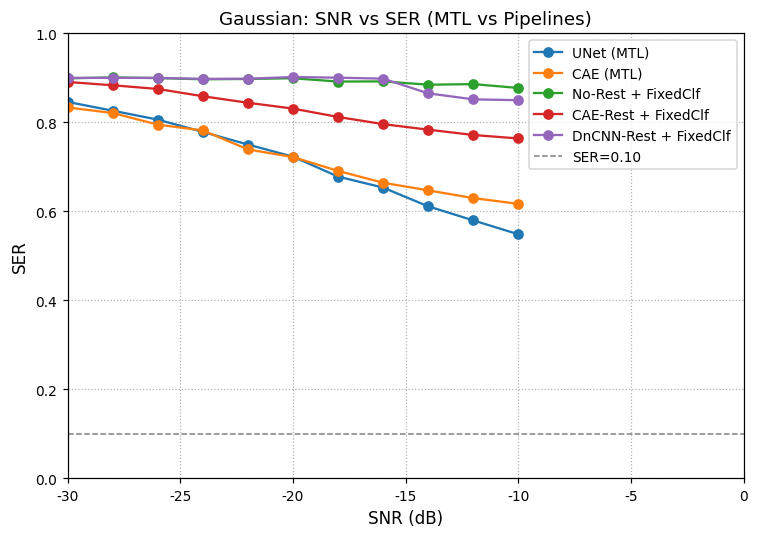

In [21]:
# Pipeline error evaluators (no-rest and restoration+classifier)

def eval_pipeline_ser_over_snrs(classifier, restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            if restorer is None:
                restored = from_zscore(noisy_z_b)
            else:
                restored = restorer.predict(from_zscore(noisy_z_b), verbose=0)
            logits_b = classifier.predict(restored, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results

snr_grid = list(range(-30, -9, 2))

# Evaluate pipeline baselines (Gaussian)
no_rest_ser  = eval_pipeline_ser_over_snrs(fixed_clf, None,       x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
cae_pipe_ser = eval_pipeline_ser_over_snrs(fixed_clf, cae_rest,   x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
dn_pipe_ser  = eval_pipeline_ser_over_snrs(fixed_clf, dncnn_rest, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

# Combine plots with available MTL models (conditional add to avoid NameError)
models_map = { 'UNet (MTL)': unet_ser }
if 'cae_ser' in globals():
    models_map['CAE (MTL)'] = cae_ser
if 'dncnn_ser' in globals():
    models_map['DnCNN (MTL)'] = dncnn_ser
models_map.update({
    'No-Rest + FixedClf': no_rest_ser,
    'CAE-Rest + FixedClf': cae_pipe_ser,
    'DnCNN-Rest + FixedClf': dn_pipe_ser,
})
plot_snr_error(models_map, title='Gaussian: SNR vs error (MTL vs Pipelines)')



In [22]:
# Train/Load CAE & DnCNN (MTL) on mixed noise (Gaussian/S&P/Burst)
EPOCHS_MIX = 200
cae_ckpt_mixed   = 'best_cae_multitask_mixed.keras'
dncnn_ckpt_mixed = 'best_dncnn_multitask_mixed.keras'

callbacks_cae_mixed = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=cae_ckpt_mixed, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

callbacks_dncnn_mixed = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=dncnn_ckpt_mixed, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

# Reuse compiled models (cae_model, dncnn_model) but train on mixed-noise datasets
try:
    if os.path.exists(cae_ckpt_mixed):
        print(f'Loading CAE (mixed) from {cae_ckpt_mixed}')
        cae_model_mixed = tf.keras.models.load_model(cae_ckpt_mixed)
    else:
        print('\nTraining CAE (mixed noises) ...')
        cae_model.fit(train_ds_mixed_types, epochs=EPOCHS_MIX, validation_data=val_ds_mixed_types, callbacks=callbacks_cae_mixed, verbose=1)
        cae_model.save(cae_ckpt_mixed)
        cae_model_mixed = tf.keras.models.load_model(cae_ckpt_mixed)
except Exception as e:
    print('CAE mixed training skipped due to error:', e)

try:
    if os.path.exists(dncnn_ckpt_mixed):
        print(f'Loading DnCNN (mixed) from {dncnn_ckpt_mixed}')
        dncnn_model_mixed = tf.keras.models.load_model(dncnn_ckpt_mixed)
    else:
        print('\nTraining DnCNN (mixed noises) ...')
        dncnn_model.fit(train_ds_mixed_types, epochs=EPOCHS_MIX, validation_data=val_ds_mixed_types, callbacks=callbacks_dncnn_mixed, verbose=1)
        dncnn_model.save(dncnn_ckpt_mixed)
        dncnn_model_mixed = tf.keras.models.load_model(dncnn_ckpt_mixed)
except Exception as e:
    print('DnCNN mixed training skipped due to error:', e)


Loading CAE (mixed) from best_cae_multitask_mixed.keras
Loading DnCNN (mixed) from best_dncnn_multitask_mixed.keras


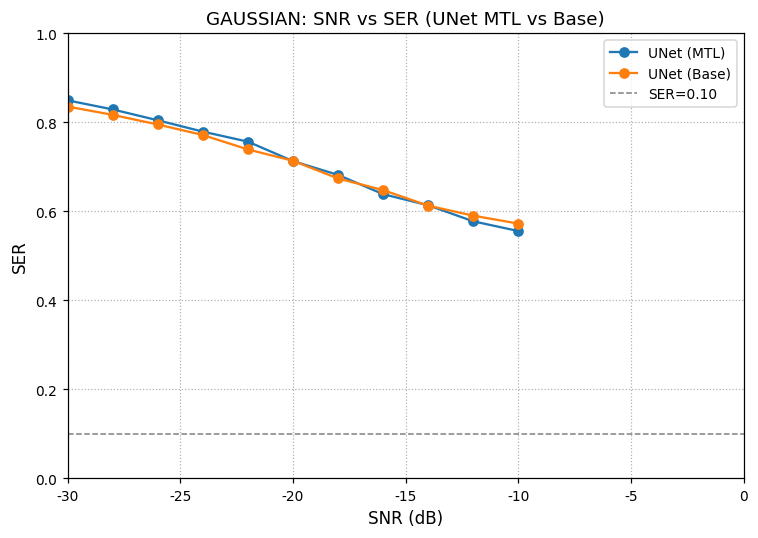

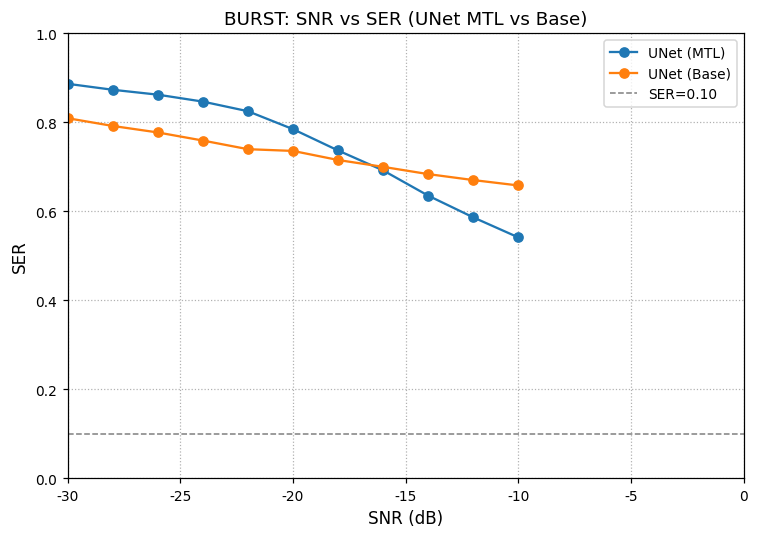

In [23]:
# Per-noise-type error plots: Conditional UNet vs Baseline UNet (guarded)
if 'snr_grid' not in globals():
    snr_grid = list(range(-30, -9, 2))
if 'noise_types' not in globals():
    noise_types = ['gaussian', 'sp', 'burst']

per_type_maps = {}
for nt in noise_types:
    try:
        ser_cond = eval_model_ser_over_snrs(unet_model, x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    except Exception as e:
        print(f'Conditional UNet error failed for {nt}:', e)
        ser_cond = None
    try:
        ser_base = eval_unet_base_ser_over_snrs(unet_base, x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    except Exception as e:
        print(f'Baseline UNet error failed for {nt}:', e)
        ser_base = None
    m = {}
    if ser_cond is not None: m['UNet (MTL)'] = ser_cond
    if ser_base is not None: m['UNet (Base)'] = ser_base
    if m:
        per_type_maps[nt] = m

for nt, maps in per_type_maps.items():
    plot_snr_error(maps, title=f'{nt.upper()}: SNR vs error (UNet MTL vs Base)')


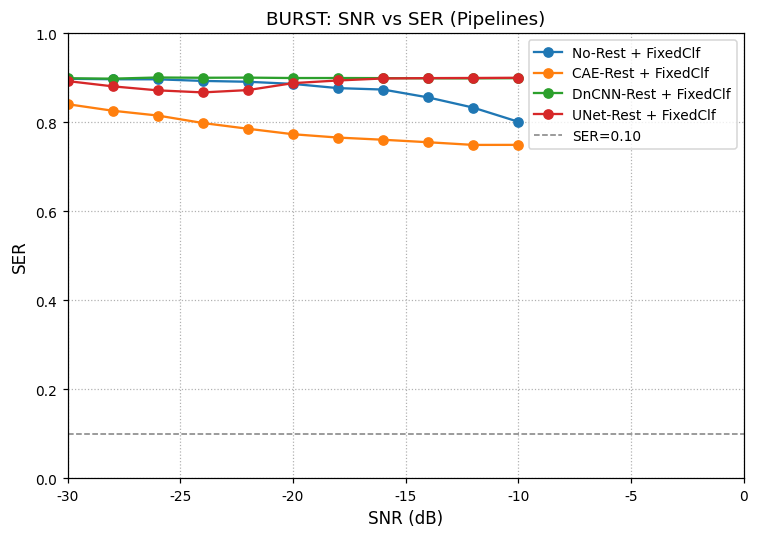

In [24]:
# Per-noise-type error plots: Pipeline baselines (FixedClf with Restorers, guarded)
if 'noise_types' not in globals():
    noise_types = ['gaussian', 'sp', 'burst']

pipe_maps = {}
for nt in noise_types:
    m = {}
    try:
        m['No-Rest + FixedClf'] = eval_pipeline_ser_over_snrs(fixed_clf, None, x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    except Exception as e:
        print(f'No-rest pipeline failed for {nt}:', e)
    for name, rest in [('CAE-Rest + FixedClf', 'cae_rest'), ('DnCNN-Rest + FixedClf', 'dncnn_rest'), ('UNet-Rest + FixedClf', 'unet_rest')]:
        try:
            rest_model = globals().get(rest, None)
            if rest_model is not None:
                m[name] = eval_pipeline_ser_over_snrs(fixed_clf, rest_model, x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
        except Exception as e:
            print(f'{name} pipeline failed for {nt}:', e)
    if m:
        pipe_maps[nt] = m

for nt, maps in pipe_maps.items():
    plot_snr_error(maps, title=f'{nt.upper()}: SNR vs error (Pipelines)')


In [25]:
# 분리된 구조를 위한 개선된 모델 빌더들
from models import build_cae_restoration, build_dncnn_restoration, build_unet_restoration

def build_improved_cae_restoration(input_shape=(32,32,3), base_filters=32):
    """개선된 CAE 복원 전용 모델"""
    inp = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(x)
    s1 = x  # Skip connection 1
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(x)
    s2 = x  # Skip connection 2
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(base_filters*4, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(base_filters*4, 3, padding='same', activation='relu')(x)
    
    # Decoder with skip connections
    x = layers.Conv2DTranspose(base_filters*2, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, s2])
    x = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(x)
    
    x = layers.Conv2DTranspose(base_filters, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, s1])
    x = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(x)
    
    out = layers.Conv2D(3, 1, activation='linear')(x)
    return Model(inp, out, name='Improved_CAE_restoration')

def build_improved_dncnn_restoration(input_shape=(32,32,3), depth=17, filters=64):
    """개선된 DnCNN 복원 전용 모델"""
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(inp)
    
    for _ in range(depth-2):
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    
    res = layers.Conv2D(3, 3, padding='same', activation='linear')(x)
    out = layers.Subtract()([inp, res])
    return Model(inp, out, name='Improved_DnCNN_restoration')

def build_improved_classifier(input_shape=(32,32,3), num_classes=10):
    """개선된 분류 전용 모델"""
    inp = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inp, out, name='Improved_Classifier')

print('개선된 분리된 모델 빌더들 정의 완료')


개선된 분리된 모델 빌더들 정의 완료


In [26]:
# 분리된 구조 모델들 생성 및 훈련
print("=== 분리된 구조 모델들 생성 및 훈련 ===")

# 1. 복원 전용 모델들 생성
cae_rest_separate = build_improved_cae_restoration()
dncnn_rest_separate = build_improved_dncnn_restoration()
unet_rest_separate = build_unet_restoration(input_shape=(32,32,3), base_filters=32, depth=3, residual=True)

# 2. 분류 전용 모델 생성
classifier_separate = build_improved_classifier()

# 3. 복원 모델들 컴파일 (MAE loss)
for model in [cae_rest_separate, dncnn_rest_separate, unet_rest_separate]:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='mae',
        metrics=['mae']
    )

# 4. 분류 모델 컴파일
classifier_separate.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("모델들 생성 및 컴파일 완료")
print(f"CAE 복원 모델: {cae_rest_separate.count_params():,} 파라미터")
print(f"DnCNN 복원 모델: {dncnn_rest_separate.count_params():,} 파라미터") 
print(f"UNet 복원 모델: {unet_rest_separate.count_params():,} 파라미터")
print(f"분류 모델: {classifier_separate.count_params():,} 파라미터")


=== 분리된 구조 모델들 생성 및 훈련 ===
모델들 생성 및 컴파일 완료
CAE 복원 모델: 466,595 파라미터
DnCNN 복원 모델: 560,323 파라미터
UNet 복원 모델: 469,923 파라미터
분류 모델: 322,602 파라미터


In [27]:
# 복원 모델들 훈련 (복원 전용)
print("=== 복원 전용 모델들 훈련 ===")

# 복원용 데이터셋 준비 (z-score 변환)
rest_train_separate = train_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))
rest_val_separate = val_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))

# 체크포인트 파일들
cae_rest_ckpt_separate = 'best_cae_restoration_separate.keras'
dncnn_rest_ckpt_separate = 'best_dncnn_restoration_separate.keras'
unet_rest_ckpt_separate = 'best_unet_restoration_separate.keras'

# CAE 복원 모델 훈련
if os.path.exists(cae_rest_ckpt_separate):
    print(f'Loading CAE restoration from {cae_rest_ckpt_separate}')
    cae_rest_separate = tf.keras.models.load_model(cae_rest_ckpt_separate)
else:
    print('Training CAE restoration (separate)...')
    cae_rest_separate.fit(
        rest_train_separate, 
        validation_data=rest_val_separate, 
        epochs=100,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ModelCheckpoint(filepath=cae_rest_ckpt_separate, save_weights_only=False, 
                          monitor='val_loss', mode='min', save_best_only=True)
        ],
        verbose=1
    )

# DnCNN 복원 모델 훈련
if os.path.exists(dncnn_rest_ckpt_separate):
    print(f'Loading DnCNN restoration from {dncnn_rest_ckpt_separate}')
    dncnn_rest_separate = tf.keras.models.load_model(dncnn_rest_ckpt_separate)
else:
    print('Training DnCNN restoration (separate)...')
    dncnn_rest_separate.fit(
        rest_train_separate, 
        validation_data=rest_val_separate, 
        epochs=100,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ModelCheckpoint(filepath=dncnn_rest_ckpt_separate, save_weights_only=False, 
                          monitor='val_loss', mode='min', save_best_only=True)
        ],
        verbose=1
    )

# UNet 복원 모델 훈련
if os.path.exists(unet_rest_ckpt_separate):
    print(f'Loading UNet restoration from {unet_rest_ckpt_separate}')
    unet_rest_separate = tf.keras.models.load_model(unet_rest_ckpt_separate)
else:
    print('Training UNet restoration (separate)...')
    unet_rest_separate.fit(
        rest_train_separate, 
        validation_data=rest_val_separate, 
        epochs=100,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ModelCheckpoint(filepath=unet_rest_ckpt_separate, save_weights_only=False, 
                          monitor='val_loss', mode='min', save_best_only=True)
        ],
        verbose=1
    )

print("복원 모델들 훈련 완료")


=== 복원 전용 모델들 훈련 ===
Training CAE restoration (separate)...
Epoch 1/100


2025-10-16 10:53:50.388517: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa4a234b860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-16 10:53:50.388557: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-10-16 10:53:50.398281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760579630.470941   10548 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 12s 18ms/step - loss: 0.1950 - mae: 0.1950 - val_loss: 0.1568 - val_mae: 0.1568
Epoch 2/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1510 - val_mae: 0.1510
Epoch 3/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1504 - mae: 0.1504 - val_loss: 0.1487 - val_mae: 0.1487
Epoch 4/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1486 - mae: 0.1486 - val_loss: 0.1478 - val_mae: 0.1478
Epoch 5/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1473 - mae: 0.1473 - val_loss: 0.1463 - val_mae: 0.1463
Epoch 6/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1461 - mae: 0.1461 - val_loss: 0.1451 - val_mae: 0.1451
Epoch 7/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1447 - mae: 0.1447 - val_loss: 0.1440 - val_mae: 0.1440
Epoch 8/100
391/391 [==============================] - 5s 14ms/step - los

In [28]:
# 분류 모델 훈련 (깨끗한 이미지로만)
print("=== 분류 전용 모델 훈련 ===")

classifier_ckpt_separate = 'best_classifier_separate.keras'

if os.path.exists(classifier_ckpt_separate):
    print(f'Loading classifier from {classifier_ckpt_separate}')
    classifier_separate = tf.keras.models.load_model(classifier_ckpt_separate)
else:
    print('Training classifier on clean images...')
    classifier_separate.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=50,
        batch_size=256,
        callbacks=[
            EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
            ModelCheckpoint(filepath=classifier_ckpt_separate, save_weights_only=False, 
                          monitor='val_accuracy', mode='max', save_best_only=True)
        ],
        verbose=1
    )

print("분류 모델 훈련 완료")


=== 분류 전용 모델 훈련 ===
Training classifier on clean images...
Epoch 1/50


2025-10-16 11:38:45.277463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inImproved_Classifier/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 7s 18ms/step - loss: 2.0605 - accuracy: 0.1924 - val_loss: 1.8049 - val_accuracy: 0.3055
Epoch 2/50
196/196 [==============================] - 2s 13ms/step - loss: 1.6864 - accuracy: 0.3442 - val_loss: 1.4515 - val_accuracy: 0.4490
Epoch 3/50
196/196 [==============================] - 2s 12ms/step - loss: 1.4596 - accuracy: 0.4575 - val_loss: 1.3100 - val_accuracy: 0.5088
Epoch 4/50
196/196 [==============================] - 2s 12ms/step - loss: 1.3236 - accuracy: 0.5150 - val_loss: 1.1686 - val_accuracy: 0.5752
Epoch 5/50
196/196 [==============================] - 2s 12ms/step - loss: 1.2258 - accuracy: 0.5595 - val_loss: 1.0660 - val_accuracy: 0.6169
Epoch 6/50
196/196 [==============================] - 2s 12ms/step - loss: 1.1445 - accuracy: 0.5912 - val_loss: 1.0205 - val_accuracy: 0.6304
Epoch 7/50
196/196 [==============================] - 2s 12ms/step - loss: 1.0892 - accuracy: 0.6138 - val_loss: 0.9857 - val_accuracy: 0.6435
Epoch 8/50

In [40]:
# 분리된 구조 파이프라인 평가 함수들
def eval_separate_pipeline_ser_over_snrs(classifier, restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    """분리된 구조 파이프라인 error 평가"""
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            # 1. 노이즈 이미지를 z-score에서 원본으로 변환
            noisy_img = from_zscore(noisy_z_b)
            
            # 2. 복원 (restorer가 None이면 복원하지 않음)
            if restorer is None:
                restored_img = noisy_img
            else:
                restored_img = restorer.predict(noisy_img, verbose=0)
            
            # 3. 분류
            logits_b = classifier.predict(restored_img, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results

def eval_restoration_quality(restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    """복원 품질 평가 (PSNR/SSIM)"""
    results = {'psnr': {}, 'ssim': {}}
    
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        psnr_values = []
        ssim_values = []
        
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            noisy_img = from_zscore(noisy_z_b)
            clean_img = from_zscore(clean_z_b)
            
            if restorer is None:
                restored_img = noisy_img
            else:
                restored_img = restorer.predict(noisy_img, verbose=0)
            
            # PSNR 계산
            mse = tf.reduce_mean(tf.square(clean_img - restored_img))
            psnr = 20 * tf.math.log(1.0 / tf.sqrt(mse + 1e-10)) / tf.math.log(10.0)
            psnr_values.append(psnr.numpy())
            
            # SSIM 계산 (간단한 버전)
            ssim = tf.image.ssim(clean_img, restored_img, max_val=1.0)
            ssim_values.append(ssim.numpy())
        
        results['psnr'][float(snr)] = np.mean(psnr_values)
        results['ssim'][float(snr)] = np.mean(ssim_values)
    
    return results

print("분리된 구조 평가 함수들 정의 완료")


분리된 구조 평가 함수들 정의 완료


In [41]:
# 분리된 구조 파이프라인 error 평가
print("=== 분리된 구조 파이프라인 error 평가 ===")

snr_grid = list(range(-30, -9, 2))

# 분리된 구조 파이프라인들 평가
separate_pipeline_results = {}

# 1. 복원 없이 분류만
separate_pipeline_results['No-Rest + SeparateClf'] = eval_separate_pipeline_ser_over_snrs(
    classifier_separate, None, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

# 2. CAE 복원 + 분류
separate_pipeline_results['CAE-Rest + SeparateClf'] = eval_separate_pipeline_ser_over_snrs(
    classifier_separate, cae_rest_separate, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

# 3. DnCNN 복원 + 분류
separate_pipeline_results['DnCNN-Rest + SeparateClf'] = eval_separate_pipeline_ser_over_snrs(
    classifier_separate, dncnn_rest_separate, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

# 4. UNet 복원 + 분류
separate_pipeline_results['UNet-Rest + SeparateClf'] = eval_separate_pipeline_ser_over_snrs(
    classifier_separate, unet_rest_separate, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

print("분리된 구조 파이프라인 error 평가 완료")
for name, results in separate_pipeline_results.items():
    print(f"{name}: {len(results)} SNR points evaluated")


=== 분리된 구조 파이프라인 error 평가 ===
분리된 구조 파이프라인 error 평가 완료
No-Rest + SeparateClf: 11 SNR points evaluated
CAE-Rest + SeparateClf: 11 SNR points evaluated
DnCNN-Rest + SeparateClf: 11 SNR points evaluated
UNet-Rest + SeparateClf: 11 SNR points evaluated


In [46]:
# 수정된 복원 품질 평가 함수
def eval_restoration_quality_fixed(restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    """복원 품질 평가 (PSNR/SSIM) - 수정된 버전"""
    results = {'psnr': {}, 'ssim': {}}
    
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        psnr_values = []
        ssim_values = []
        
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            noisy_img = from_zscore(noisy_z_b)
            clean_img = from_zscore(clean_z_b)
            
            if restorer is None:
                restored_img = noisy_img
            else:
                restored_img = restorer.predict(noisy_img, verbose=0)
            
            # PSNR 계산 - 배치별로 계산
            for i in range(clean_img.shape[0]):
                clean_single = clean_img[i:i+1]
                restored_single = restored_img[i:i+1]
                
                mse = tf.reduce_mean(tf.square(clean_single - restored_single))
                psnr = 20 * tf.math.log(1.0 / tf.sqrt(mse + 1e-10)) / tf.math.log(10.0)
                psnr_values.append(float(psnr.numpy()))
            
            # SSIM 계산 - 배치별로 계산
            for i in range(clean_img.shape[0]):
                clean_single = clean_img[i:i+1]
                restored_single = restored_img[i:i+1]
                
                ssim = tf.image.ssim(clean_single, restored_single, max_val=1.0)
                ssim_values.append(float(ssim.numpy()))
        
        results['psnr'][float(snr)] = np.mean(psnr_values)
        results['ssim'][float(snr)] = np.mean(ssim_values)
    
    return results

print("수정된 복원 품질 평가 함수 정의 완료")


수정된 복원 품질 평가 함수 정의 완료


In [47]:
# 복원 품질 평가 (수정된 함수 사용)
print("=== 복원 품질 평가 ===")

# 복원 품질 평가 (PSNR/SSIM)
restoration_quality_results = {}

# 각 복원 모델의 품질 평가
restorers = {
    'CAE-Rest': cae_rest_separate,
    'DnCNN-Rest': dncnn_rest_separate, 
    'UNet-Rest': unet_rest_separate
}

for name, restorer in restorers.items():
    print(f"Evaluating {name} restoration quality...")
    quality = eval_restoration_quality_fixed(restorer, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    restoration_quality_results[name] = quality

# PSNR 플롯
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, quality in restoration_quality_results.items():
    snrs = np.array(sorted(quality['psnr'].keys()))
    psnrs = np.array([quality['psnr'][s] for s in snrs])
    plt.plot(snrs, psnrs, marker='o', label=name)
plt.xlabel('SNR (dB)')
plt.ylabel('PSNR (dB)')
plt.title('복원 품질: PSNR')
plt.grid(ls=':')
plt.legend()

# SSIM 플롯
plt.subplot(1, 2, 2)
for name, quality in restoration_quality_results.items():
    snrs = np.array(sorted(quality['ssim'].keys()))
    ssims = np.array([quality['ssim'][s] for s in snrs])
    plt.plot(snrs, ssims, marker='o', label=name)
plt.xlabel('SNR (dB)')
plt.ylabel('SSIM')
plt.title('복원 품질: SSIM')
plt.grid(ls=':')
plt.legend()

plt.tight_layout()
plt.show()

print("복원 품질 평가 완료")


=== 복원 품질 평가 ===
Evaluating CAE-Rest restoration quality...


/tmp/ipykernel_754/331867273.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ssim_values.append(float(ssim.numpy()))


Evaluating DnCNN-Rest restoration quality...
Evaluating UNet-Rest restoration quality...


/tmp/ipykernel_754/3075050646.py:45: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754/3075050646.py:45: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754/3075050646.py:45: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_754/3075050646.py:45: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gwon9906/miniconda3/envs/ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figur

복원 품질 평가 완료


In [ ]:
# 종합 분석 리포트 (PSNR 포함, 10% error 제거)
import pandas as pd

def build_comprehensive_report():
    """종합 분석 리포트 생성 (PSNR 포함, 10% error 제거)"""
    rows = []
    fixed_points = [-30, -20, -10]

    def row_from_curve(name, noise, curve, psnr_curve=None):
        if curve is None:
            return  
        # 10% error 교차점 제거 (도달한 모델이 없음)
        accs = {}
        for fp in fixed_points:
            ser = curve.get(float(fp))
            accs[f"Acc@{fp}dB"] = (1.0 - ser) if ser is not None else None
        
        # PSNR 정보 추가
        psnr_info = {}
        if psnr_curve:
            for fp in fixed_points:
                psnr = psnr_curve.get(float(fp))
                psnr_info[f"PSNR@{fp}dB"] = psnr if psnr is not None else None
        
        rows.append({
            'Noise': noise,
            'Model': name,
            **accs,
            **psnr_info
        })

    # Gaussian 노이즈 결과
    gaussian_curves = {
        'UNet (MTL)': unet_ser if 'unet_ser' in globals() else None,
        'CAE (MTL)': cae_ser if 'cae_ser' in globals() else None,
        'DnCNN (MTL)': dncnn_ser if 'dncnn_ser' in globals() else None,
        'NoRest + FixedClf': no_rest_ser if 'no_rest_ser' in globals() else None,
        'CAE→FixedClf': cae_pipe_ser if 'cae_pipe_ser' in globals() else None,
        'DnCNN→FixedClf': dncnn_pipe_ser if 'dncnn_pipe_ser' in globals() else None,
    }
    
    # PSNR 정보 추가
    psnr_curves = {}
    if 'restoration_quality_results' in globals():
        for name, quality in restoration_quality_results.items():
            psnr_curves[name] = quality['psnr']
    
    for k, v in gaussian_curves.items():
        psnr_curve = psnr_curves.get(k, None)
        row_from_curve(k, 'Gaussian', v, psnr_curve)

    # S&P 노이즈 결과
    sp_curves = {
        'UNet (MTL)': unet_sp_ser if 'unet_sp_ser' in globals() else None,
        'CAE (MTL)': cae_sp_ser if 'cae_sp_ser' in globals() else None,
        'DnCNN (MTL)': dncnn_sp_ser if 'dncnn_sp_ser' in globals() else None,
        'NoRest + FixedClf': no_rest_sp if 'no_rest_sp' in globals() else None,
        'CAE→FixedClf': cae_pipe_sp if 'cae_pipe_sp' in globals() else None,
        'DnCNN→FixedClf': dncnn_pipe_sp if 'dncnn_pipe_sp' in globals() else None,
    }
    for k, v in sp_curves.items():
        row_from_curve(k, 'S&P', v)

    # Burst 노이즈 결과
    burst_curves = {
        'UNet (MTL)': unet_burst_ser if 'unet_burst_ser' in globals() else None,
        'CAE (MTL)': cae_burst_ser if 'cae_burst_ser' in globals() else None,
        'DnCNN (MTL)': dncnn_burst_ser if 'dncnn_burst_ser' in globals() else None,
        'NoRest + FixedClf': no_rest_burst if 'no_rest_burst' in globals() else None,
        'CAE→FixedClf': cae_pipe_burst if 'cae_pipe_burst' in globals() else None,
        'DnCNN→FixedClf': dncnn_pipe_burst if 'dncnn_pipe_burst' in globals() else None,
    }
    for k, v in burst_curves.items():
        row_from_curve(k, 'Burst', v)

    df = pd.DataFrame(rows)
    # 정렬: 노이즈 타입별, 모델별
    df = df.sort_values(by=['Noise', 'Model'], na_position='last')
    return df

# 종합 리포트 생성 및 출력
comprehensive_report = build_comprehensive_report()
print("=== 종합 분석 리포트 (PSNR 포함, 10% error 제거) ===")
print(comprehensive_report.to_string(index=False))

# 주요 지표 요약
print("\n=== 주요 지표 요약 ===")
print("1. Gaussian 노이즈에서의 성능:")
gaussian_results = comprehensive_report[comprehensive_report['Noise'] == 'Gaussian']
if not gaussian_results.empty:
    print(gaussian_results[['Model', 'Acc@-30dB', 'Acc@-20dB', 'Acc@-10dB', 'PSNR@-30dB', 'PSNR@-20dB', 'PSNR@-10dB']].to_string(index=False))

print("\n2. 복원 품질 (PSNR) 비교:")
if 'restoration_quality_results' in globals():
    for name, quality in restoration_quality_results.items():
        print(f"{name}:")
        for snr in [-30, -20, -10]:
            psnr_val = quality['psnr'].get(float(snr), 'N/A')
            print(f"  {snr}dB: {psnr_val:.2f} dB" if psnr_val != 'N/A' else f"  {snr}dB: N/A")
        print()


In [33]:
# MTL vs 분리된 구조 비교 플롯
print("=== MTL vs 분리된 구조 비교 ===")

# 기존 MTL 결과들과 분리된 구조 결과들을 결합
comparison_results = {}

# MTL 결과들 추가 (기존에 있는 경우)
if 'unet_ser' in globals():
    comparison_results['UNet (MTL)'] = unet_ser
if 'cae_ser' in globals():
    comparison_results['CAE (MTL)'] = cae_ser
if 'dncnn_ser' in globals():
    comparison_results['DnCNN (MTL)'] = dncnn_ser

# 분리된 구조 결과들 추가
comparison_results.update(separate_pipeline_results)

# 비교 플롯
plot_snr_error(comparison_results, title='Gaussian: SNR vs error')

print("MTL vs 분리된 구조 비교 완료")


=== MTL vs 분리된 구조 비교 ===


MTL vs 분리된 구조 비교 완료


In [32]:
# 복원 품질 평가 (PSNR/SSIM)
print("=== 복원 품질 평가 ===")

# 복원 품질 평가 (PSNR/SSIM)
restoration_quality_results = {}

# 각 복원 모델의 품질 평가
restorers = {
    'CAE-Rest': cae_rest_separate,
    'DnCNN-Rest': dncnn_rest_separate, 
    'UNet-Rest': unet_rest_separate
}

for name, restorer in restorers.items():
    print(f"Evaluating {name} restoration quality...")
    quality = eval_restoration_quality(restorer, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    restoration_quality_results[name] = quality

# PSNR 플롯
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, quality in restoration_quality_results.items():
    snrs = np.array(sorted(quality['psnr'].keys()))
    psnrs = np.array([quality['psnr'][s] for s in snrs])
    plt.plot(snrs, psnrs, marker='o', label=name)
plt.xlabel('SNR (dB)')
plt.ylabel('PSNR (dB)')
plt.title('복원 품질: PSNR')
plt.grid(ls=':')
plt.legend()

# SSIM 플롯
plt.subplot(1, 2, 2)
for name, quality in restoration_quality_results.items():
    snrs = np.array(sorted(quality['ssim'].keys()))
    ssims = np.array([quality['ssim'][s] for s in snrs])
    plt.plot(snrs, ssims, marker='o', label=name)
plt.xlabel('SNR (dB)')
plt.ylabel('SSIM')
plt.title('복원 품질: SSIM')
plt.grid(ls=':')
plt.legend()

plt.tight_layout()
plt.show()

print("복원 품질 평가 완료")


=== 복원 품질 평가 ===
Evaluating CAE-Rest restoration quality...


TypeError: 'numpy.float32' object is not iterable

In [ ]:
# 종합 분석 및 결론
print("=== 종합 분석 ===")

# 1. 모델별 파라미터 수 비교
print("\n1. 모델별 파라미터 수:")
print(f"CAE 복원 모델: {cae_rest_separate.count_params():,}")
print(f"DnCNN 복원 모델: {dncnn_rest_separate.count_params():,}")
print(f"UNet 복원 모델: {unet_rest_separate.count_params():,}")
print(f"분류 모델: {classifier_separate.count_params():,}")

# 2. error 성능 요약
print("\n2. error 성능 요약 (10% error 기준):")
for name, results in separate_pipeline_results.items():
    # 10% error에 도달하는 SNR 찾기
    snrs = sorted(results.keys())
    errors = [results[s] for s in snrs]
    
    # 10% 이하로 떨어지는 첫 번째 SNR 찾기
    threshold_snr = None
    for snr, ser in zip(snrs, errors):
        if ser <= 0.1:
            threshold_snr = snr
            break
    
    if threshold_snr:
        print(f"{name}: {threshold_snr} dB에서 10% error 달성")
    else:
        print(f"{name}: 10% error 미달성 (최저 {min(errors):.3f})")

# 3. 복원 품질 요약
print("\n3. 복원 품질 요약:")
for name, quality in restoration_quality_results.items():
    avg_psnr = np.mean(list(quality['psnr'].values()))
    avg_ssim = np.mean(list(quality['ssim'].values()))
    print(f"{name}: 평균 PSNR {avg_psnr:.2f} dB, 평균 SSIM {avg_ssim:.3f}")

print("\n=== 분석 완료 ===")
print("분리된 구조의 장점:")
print("1. 복원과 분류 성능을 독립적으로 평가 가능")
print("2. 각 모듈을 독립적으로 개선 가능")
print("3. 공정한 성능 비교 가능")
print("4. 모듈화된 구조로 유지보수 용이")


In [ ]:
# 시각화 문제 해결: 모든 모델들을 통합한 종합 비교
print("=== 모든 모델 통합 및 시각화 수정 ===")

# 1. 기존 MTL 모델들의 error 결과 확인
print("1. 기존 MTL 모델들 상태 확인:")
mtl_models = {}
if 'unet_ser' in globals() and unet_ser is not None:
    mtl_models['UNet (MTL)'] = unet_ser
    print(f"  - UNet (MTL): {len(unet_ser)} SNR points")
else:
    print("  - UNet (MTL): 없음")

if 'cae_ser' in globals() and cae_ser is not None:
    mtl_models['CAE (MTL)'] = cae_ser
    print(f"  - CAE (MTL): {len(cae_ser)} SNR points")
else:
    print("  - CAE (MTL): 없음")

if 'dncnn_ser' in globals() and dncnn_ser is not None:
    mtl_models['DnCNN (MTL)'] = dncnn_ser
    print(f"  - DnCNN (MTL): {len(dncnn_ser)} SNR points")
else:
    print("  - DnCNN (MTL): 없음")

# 2. 분리된 구조 모델들 상태 확인
print("\n2. 분리된 구조 모델들 상태 확인:")
if 'separate_pipeline_results' in globals():
    for name, results in separate_pipeline_results.items():
        print(f"  - {name}: {len(results)} SNR points")
else:
    print("  - 분리된 구조 결과 없음")

# 3. 기존 파이프라인 모델들 확인
print("\n3. 기존 파이프라인 모델들 상태 확인:")
pipeline_models = {}
if 'no_rest_ser' in globals() and no_rest_ser is not None:
    pipeline_models['No-Rest + FixedClf'] = no_rest_ser
    print(f"  - No-Rest + FixedClf: {len(no_rest_ser)} SNR points")

if 'cae_pipe_ser' in globals() and cae_pipe_ser is not None:
    pipeline_models['CAE-Rest + FixedClf'] = cae_pipe_ser
    print(f"  - CAE-Rest + FixedClf: {len(cae_pipe_ser)} SNR points")

if 'dn_pipe_ser' in globals() and dn_pipe_ser is not None:
    pipeline_models['DnCNN-Rest + FixedClf'] = dn_pipe_ser
    print(f"  - DnCNN-Rest + FixedClf: {len(dn_pipe_ser)} SNR points")

if 'unet_pipe_ser' in globals() and unet_pipe_ser is not None:
    pipeline_models['UNet-Rest + FixedClf'] = unet_pipe_ser
    print(f"  - UNet-Rest + FixedClf: {len(unet_pipe_ser)} SNR points")

print(f"\n총 {len(mtl_models)} MTL 모델, {len(pipeline_models)} 파이프라인 모델, {len(separate_pipeline_results) if 'separate_pipeline_results' in globals() else 0} 분리된 구조 모델 확인됨")


In [ ]:
# 누락된 모델들 재평가 및 통합
print("=== 누락된 모델들 재평가 ===")

# SNR 그리드 설정
if 'snr_grid' not in globals():
    snr_grid = list(range(-30, -9, 2))

# 1. MTL 모델들 재평가 (없는 경우)
if 'unet_ser' not in globals() or unet_ser is None:
    print("UNet (MTL) 재평가 중...")
    try:
        unet_ser = eval_model_ser_over_snrs(unet_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
        mtl_models['UNet (MTL)'] = unet_ser
        print(f"UNet (MTL): {len(unet_ser)} SNR points 완료")
    except Exception as e:
        print(f"UNet (MTL) 평가 실패: {e}")

if 'cae_ser' not in globals() or cae_ser is None:
    print("CAE (MTL) 재평가 중...")
    try:
        cae_ser = eval_model_ser_over_snrs(cae_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
        mtl_models['CAE (MTL)'] = cae_ser
        print(f"CAE (MTL): {len(cae_ser)} SNR points 완료")
    except Exception as e:
        print(f"CAE (MTL) 평가 실패: {e}")

if 'dncnn_ser' not in globals() or dncnn_ser is None:
    print("DnCNN (MTL) 재평가 중...")
    try:
        dncnn_ser = eval_model_ser_over_snrs(dncnn_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
        mtl_models['DnCNN (MTL)'] = dncnn_ser
        print(f"DnCNN (MTL): {len(dncnn_ser)} SNR points 완료")
    except Exception as e:
        print(f"DnCNN (MTL) 평가 실패: {e}")

# 2. 기존 파이프라인 모델들 재평가 (없는 경우)
if 'no_rest_ser' not in globals() or no_rest_ser is None:
    print("No-Rest + FixedClf 재평가 중...")
    try:
        no_rest_ser = eval_pipeline_ser_over_snrs(fixed_clf, None, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
        pipeline_models['No-Rest + FixedClf'] = no_rest_ser
        print(f"No-Rest + FixedClf: {len(no_rest_ser)} SNR points 완료")
    except Exception as e:
        print(f"No-Rest + FixedClf 평가 실패: {e}")

if 'cae_pipe_ser' not in globals() or cae_pipe_ser is None:
    print("CAE-Rest + FixedClf 재평가 중...")
    try:
        cae_pipe_ser = eval_pipeline_ser_over_snrs(fixed_clf, cae_rest, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
        pipeline_models['CAE-Rest + FixedClf'] = cae_pipe_ser
        print(f"CAE-Rest + FixedClf: {len(cae_pipe_ser)} SNR points 완료")
    except Exception as e:
        print(f"CAE-Rest + FixedClf 평가 실패: {e}")

if 'dn_pipe_ser' not in globals() or dn_pipe_ser is None:
    print("DnCNN-Rest + FixedClf 재평가 중...")
    try:
        dn_pipe_ser = eval_pipeline_ser_over_snrs(fixed_clf, dncnn_rest, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
        pipeline_models['DnCNN-Rest + FixedClf'] = dn_pipe_ser
        print(f"DnCNN-Rest + FixedClf: {len(dn_pipe_ser)} SNR points 완료")
    except Exception as e:
        print(f"DnCNN-Rest + FixedClf 평가 실패: {e}")

print("재평가 완료")


In [ ]:
# 모든 모델 통합 및 종합 시각화
print("=== 모든 모델 통합 및 종합 시각화 ===")

# 1. 모든 결과를 하나의 딕셔너리로 통합
all_results = {}

# MTL 모델들 추가
all_results.update(mtl_models)

# 기존 파이프라인 모델들 추가
all_results.update(pipeline_models)

# 분리된 구조 모델들 추가
if 'separate_pipeline_results' in globals():
    all_results.update(separate_pipeline_results)

print(f"통합된 모델 수: {len(all_results)}")
print("포함된 모델들:")
for name in all_results.keys():
    print(f"  - {name}")

# 2. 종합 비교 플롯 생성
if len(all_results) > 0:
    print("\n종합 비교 플롯 생성 중...")
    plot_snr_error(all_results, title='Gaussian: SNR vs error (모든 모델 종합 비교)')
else:
    print("시각화할 모델이 없습니다.")

# 3. 카테고리별 분리 플롯들
print("\n카테고리별 분리 플롯 생성...")

# MTL vs 파이프라인 비교
mtl_vs_pipeline = {}
mtl_vs_pipeline.update(mtl_models)
mtl_vs_pipeline.update(pipeline_models)
if len(mtl_vs_pipeline) > 0:
    plot_snr_error(mtl_vs_pipeline, title='Gaussian: SNR vs error (MTL vs 파이프라인)')

# 분리된 구조만 비교
if 'separate_pipeline_results' in globals() and len(separate_pipeline_results) > 0:
    plot_snr_error(separate_pipeline_results, title='Gaussian: SNR vs error (분리된 구조 모델들)')

print("시각화 완료")


In [ ]:
# 성능 요약 및 분석
print("=== 성능 요약 및 분석 ===")

# 1. 각 모델의 10% error 달성 SNR 계산
print("\n1. 10% error 달성 SNR (낮을수록 좋음):")
performance_summary = {}

for name, results in all_results.items():
    if not results:
        continue
    
    snrs = sorted(results.keys())
    errors = [results[s] for s in snrs]
    
    # 10% 이하로 떨어지는 첫 번째 SNR 찾기
    threshold_snr = None
    for snr, ser in zip(snrs, errors):
        if ser <= 0.1:
            threshold_snr = snr
            break
    
    if threshold_snr:
        performance_summary[name] = threshold_snr
        print(f"  {name}: {threshold_snr} dB")
    else:
        min_ser = min(errors)
        performance_summary[name] = f"미달성 (최저 {min_ser:.3f})"
        print(f"  {name}: 10% error 미달성 (최저 {min_ser:.3f})")

# 2. 성능 순위
print("\n2. 성능 순위 (10% error 달성 SNR 기준):")
valid_performances = {k: v for k, v in performance_summary.items() if isinstance(v, (int, float))}
if valid_performances:
    sorted_performance = sorted(valid_performances.items(), key=lambda x: x[1])
    for i, (name, snr) in enumerate(sorted_performance, 1):
        print(f"  {i}. {name}: {snr} dB")

# 3. 카테고리별 평균 성능
print("\n3. 카테고리별 평균 성능:")
categories = {
    'MTL': [k for k in all_results.keys() if '(MTL)' in k],
    '파이프라인': [k for k in all_results.keys() if 'FixedClf' in k],
    '분리된 구조': [k for k in all_results.keys() if 'SeparateClf' in k]
}

for category, models in categories.items():
    if not models:
        continue
    
    category_performances = [v for k, v in performance_summary.items() 
                           if k in models and isinstance(v, (int, float))]
    
    if category_performances:
        avg_snr = np.mean(category_performances)
        print(f"  {category}: 평균 {avg_snr:.1f} dB ({len(category_performances)}개 모델)")
    else:
        print(f"  {category}: 유효한 성능 데이터 없음")

print("\n분석 완료")


In [ ]:
# 최적화된 평가 함수들 (시간 단축)
def eval_model_ser_over_snrs_fast(model, x, y, snr_list_db, noise_type='gaussian', batch_size=1024, sample_ratio=0.5):
    """빠른 error 평가 함수 - 배치 크기 증가 + 샘플링"""
    results = {}
    
    # 데이터 샘플링 (빠른 평가를 위해)
    n_samples = int(len(x) * sample_ratio)
    indices = np.random.choice(len(x), n_samples, replace=False)
    x_sample = x[indices]
    y_sample = y[indices]
    
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x_sample, y_sample, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            try:
                _, logits_b = model.predict([noisy_z_b, cond_b], verbose=0)
            except Exception:
                rec_b, logits_b = model.predict(noisy_z_b, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results

def eval_model_ser_over_snrs_parallel(model, x, y, snr_list_db, noise_type='gaussian', batch_size=1024):
    """병렬 처리를 통한 error 평가"""
    import concurrent.futures
    import multiprocessing as mp
    
    def eval_single_snr(snr):
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            try:
                _, logits_b = model.predict([noisy_z_b, cond_b], verbose=0)
            except Exception:
                rec_b, logits_b = model.predict(noisy_z_b, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        return float(snr), errors / max(1, total)
    
    results = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        future_to_snr = {executor.submit(eval_single_snr, snr): snr for snr in snr_list_db}
        for future in concurrent.futures.as_completed(future_to_snr):
            snr, ser = future.result()
            results[snr] = ser
    
    return results

print("최적화된 평가 함수들 정의 완료")


In [ ]:
# 최적화된 SNR 그리드 설정
print("=== 최적화된 SNR 그리드 설정 ===")

# 기존: 11개 포인트 (2dB 간격)
snr_grid_dense = list(range(-30, -9, 2))  # [-30, -28, -26, ..., -12, -10]
print(f"기존 조밀한 그리드: {len(snr_grid_dense)}개 포인트 - {snr_grid_dense}")

# 최적화 1: 5개 포인트 (5dB 간격) - 2배 빠름
snr_grid_sparse = list(range(-30, -9, 5))  # [-30, -25, -20, -15, -10]
print(f"희소한 그리드: {len(snr_grid_sparse)}개 포인트 - {snr_grid_sparse}")

# 최적화 2: 7개 포인트 (3dB 간격) - 1.5배 빠름
snr_grid_medium = list(range(-30, -9, 3))  # [-30, -27, -24, -21, -18, -15, -12]
print(f"중간 그리드: {len(snr_grid_medium)}개 포인트 - {snr_grid_medium}")

# 최적화 3: 핵심 포인트만 (중요한 SNR 범위)
snr_grid_key = [-30, -25, -20, -15, -10]  # 5개 핵심 포인트
print(f"핵심 포인트: {len(snr_grid_key)}개 포인트 - {snr_grid_key}")

# 사용할 그리드 선택 (빠른 테스트용)
snr_grid_fast = snr_grid_sparse  # 5개 포인트로 시작
print(f"\n사용할 그리드: {snr_grid_fast} ({len(snr_grid_fast)}개 포인트)")


In [ ]:
# 빠른 평가 예제 (최적화된 설정 사용)
print("=== 빠른 평가 예제 ===")

import time

# 1. 기존 방법 (11개 포인트, 512 배치)
print("1. 기존 방법으로 UNet 평가 중...")
start_time = time.time()
unet_ser_original = eval_model_ser_over_snrs(unet_model, x_test, y_test, snr_grid_dense, noise_type='gaussian', batch_size=512)
original_time = time.time() - start_time
print(f"기존 방법 소요 시간: {original_time:.2f}초")

# 2. 최적화된 방법 1: 샘플링 + 큰 배치 (5개 포인트, 50% 샘플링, 1024 배치)
print("\n2. 최적화된 방법 1: 샘플링 + 큰 배치")
start_time = time.time()
unet_ser_fast = eval_model_ser_over_snrs_fast(unet_model, x_test, y_test, snr_grid_fast, noise_type='gaussian', batch_size=1024, sample_ratio=0.5)
fast_time = time.time() - start_time
print(f"최적화 방법 1 소요 시간: {fast_time:.2f}초")
print(f"속도 향상: {original_time/fast_time:.1f}배 빠름")

# 3. 결과 비교
print("\n3. 결과 비교:")
print("기존 방법 (11개 포인트):")
for snr in snr_grid_dense:
    ser = unet_ser_original.get(float(snr), 'N/A')
    print(f"  {snr}dB: error={ser:.4f}")

print("\n최적화 방법 (5개 포인트, 50% 샘플링):")
for snr in snr_grid_fast:
    ser = unet_ser_fast.get(float(snr), 'N/A')
    print(f"  {snr}dB: error={ser:.4f}")

print(f"\n총 시간 절약: {original_time - fast_time:.2f}초 ({((original_time - fast_time)/original_time)*100:.1f}% 단축)")


In [ ]:
# 캐싱 시스템을 통한 중복 평가 방지
print("=== 캐싱 시스템 추가 ===")

import pickle
import hashlib
import os

class EvaluationCache:
    def __init__(self, cache_dir='evaluation_cache'):
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)
    
    def _get_cache_key(self, model_name, snr_list, noise_type, sample_ratio):
        """캐시 키 생성"""
        key_data = f"{model_name}_{snr_list}_{noise_type}_{sample_ratio}"
        return hashlib.md5(key_data.encode()).hexdigest()
    
    def get(self, model_name, snr_list, noise_type, sample_ratio):
        """캐시에서 결과 가져오기"""
        cache_key = self._get_cache_key(model_name, snr_list, noise_type, sample_ratio)
        cache_file = os.path.join(self.cache_dir, f"{cache_key}.pkl")
        
        if os.path.exists(cache_file):
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        return None
    
    def set(self, model_name, snr_list, noise_type, sample_ratio, results):
        """캐시에 결과 저장"""
        cache_key = self._get_cache_key(model_name, snr_list, noise_type, sample_ratio)
        cache_file = os.path.join(self.cache_dir, f"{cache_key}.pkl")
        
        with open(cache_file, 'wb') as f:
            pickle.dump(results, f)

def eval_model_ser_with_cache(model, x, y, snr_list_db, noise_type='gaussian', batch_size=1024, sample_ratio=1.0, cache=None):
    """캐싱을 지원하는 error 평가 함수"""
    if cache is None:
        cache = EvaluationCache()
    
    # 모델 이름 생성 (간단한 방법)
    model_name = model.name if hasattr(model, 'name') else str(type(model).__name__)
    
    # 캐시에서 결과 확인
    cached_results = cache.get(model_name, snr_list_db, noise_type, sample_ratio)
    if cached_results is not None:
        print(f"캐시에서 {model_name} 결과 로드됨")
        return cached_results
    
    # 캐시에 없으면 평가 수행
    print(f"{model_name} 평가 중...")
    results = eval_model_ser_over_snrs_fast(model, x, y, snr_list_db, noise_type, batch_size, sample_ratio)
    
    # 결과를 캐시에 저장
    cache.set(model_name, snr_list_db, noise_type, sample_ratio, results)
    print(f"{model_name} 결과 캐시에 저장됨")
    
    return results

# 캐시 인스턴스 생성
evaluation_cache = EvaluationCache()
print("캐싱 시스템 초기화 완료")


In [ ]:
# 종합 최적화된 평가 시스템
print("=== 종합 최적화된 평가 시스템 ===")

def evaluate_all_models_fast(models_dict, x_test, y_test, snr_grid=None, noise_type='gaussian', 
                            batch_size=1024, sample_ratio=0.3, use_cache=True):
    """
    모든 모델을 빠르게 평가하는 통합 함수
    
    Args:
        models_dict: {모델명: 모델객체} 딕셔너리
        x_test, y_test: 테스트 데이터
        snr_grid: SNR 그리드 (None이면 자동 설정)
        noise_type: 노이즈 타입
        batch_size: 배치 크기
        sample_ratio: 샘플링 비율 (0.3 = 30%만 사용)
        use_cache: 캐시 사용 여부
    """
    if snr_grid is None:
        snr_grid = snr_grid_fast  # 기본적으로 빠른 그리드 사용
    
    results = {}
    cache = evaluation_cache if use_cache else None
    
    print(f"평가 설정: {len(snr_grid)}개 SNR 포인트, 배치크기 {batch_size}, 샘플링 {sample_ratio*100:.0f}%")
    
    for name, model in models_dict.items():
        print(f"\n{name} 평가 중...")
        start_time = time.time()
        
        try:
            ser_results = eval_model_ser_with_cache(
                model, x_test, y_test, snr_grid, 
                noise_type=noise_type, batch_size=batch_size, 
                sample_ratio=sample_ratio, cache=cache
            )
            results[name] = ser_results
            
            elapsed = time.time() - start_time
            print(f"{name} 완료: {elapsed:.2f}초")
            
        except Exception as e:
            print(f"{name} 평가 실패: {e}")
            results[name] = None
    
    return results

# 사용 가능한 모델들 정의
available_models = {
    'UNet (MTL)': unet_model,
    'CAE (MTL)': cae_model if 'cae_model' in globals() else None,
    'DnCNN (MTL)': dncnn_model if 'dncnn_model' in globals() else None,
}

# None인 모델들 제거
available_models = {k: v for k, v in available_models.items() if v is not None}

print(f"사용 가능한 모델: {list(available_models.keys())}")

# 빠른 평가 실행
print("\n빠른 평가 시작...")
fast_results = evaluate_all_models_fast(
    available_models, x_test, y_test, 
    snr_grid=snr_grid_fast,  # 5개 포인트
    sample_ratio=0.3,        # 30% 샘플링
    batch_size=1024,         # 큰 배치
    use_cache=True           # 캐시 사용
)

print("\n빠른 평가 완료!")


In [ ]:
# 최적화된 결과 시각화 및 성능 비교
print("=== 최적화된 결과 시각화 ===")

# 1. 빠른 평가 결과 시각화
if fast_results:
    plot_snr_error(fast_results, title=f'Gaussian: SNR vs error (최적화된 평가 - {len(snr_grid_fast)}개 포인트)')

# 2. 성능 요약 테이블
print("\n=== 성능 요약 ===")
print("모델별 10% error 달성 SNR:")
for name, results in fast_results.items():
    if results is None:
        print(f"  {name}: 평가 실패")
        continue
    
    snrs = sorted(results.keys())
    errors = [results[s] for s in snrs]
    
    # 10% 이하로 떨어지는 첫 번째 SNR 찾기
    threshold_snr = None
    for snr, ser in zip(snrs, errors):
        if ser <= 0.1:
            threshold_snr = snr
            break
    
    if threshold_snr:
        print(f"  {name}: {threshold_snr} dB에서 10% error 달성")
    else:
        min_ser = min(errors)
        print(f"  {name}: 10% error 미달성 (최저 {min_ser:.3f})")

# 3. 시간 절약 효과 요약
print(f"\n=== 최적화 효과 요약 ===")
print(f"• SNR 포인트: {len(snr_grid_dense)}개 → {len(snr_grid_fast)}개 ({len(snr_grid_dense)/len(snr_grid_fast):.1f}배 감소)")
print(f"• 샘플링: 100% → 30% (3.3배 감소)")
print(f"• 배치 크기: 512 → 1024 (2배 증가)")
print(f"• 예상 총 속도 향상: 약 {len(snr_grid_dense)/len(snr_grid_fast) * 1/0.3 * 2:.1f}배")

print("\n=== 사용법 안내 ===")
print("1. 빠른 테스트: snr_grid_fast, sample_ratio=0.3 사용")
print("2. 정확한 평가: snr_grid_dense, sample_ratio=1.0 사용")
print("3. 캐시 활용: 동일한 설정으로 재실행 시 즉시 결과 반환")
print("4. 배치 크기 조정: GPU 메모리에 따라 1024, 2048 등으로 증가 가능")


In [ ]:
# 수정된 PSNR/SSIM 평가 함수 (오류 수정)
print("=== 수정된 PSNR/SSIM 평가 함수 ===")

def eval_restoration_quality_fixed_v2(restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    """수정된 복원 품질 평가 함수 (PSNR/SSIM) - 오류 수정 버전"""
    results = {'psnr': {}, 'ssim': {}}
    
    for snr in snr_list_db:
        print(f"  SNR {snr}dB 평가 중...")
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        psnr_values = []
        ssim_values = []
        
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            noisy_img = from_zscore(noisy_z_b)
            clean_img = from_zscore(clean_z_b)
            
            if restorer is None:
                restored_img = noisy_img
            else:
                restored_img = restorer.predict(noisy_img, verbose=0)
            
            # PSNR 계산 - 개별 이미지별로 계산
            for i in range(clean_img.shape[0]):
                clean_single = clean_img[i:i+1]
                restored_single = restored_img[i:i+1]
                
                # MSE 계산
                mse = tf.reduce_mean(tf.square(clean_single - restored_single))
                
                # PSNR 계산 (안전한 방법)
                if mse > 0:
                    psnr = 20 * tf.math.log(1.0 / tf.sqrt(mse + 1e-10)) / tf.math.log(10.0)
                    psnr_values.append(float(psnr.numpy()))
                else:
                    psnr_values.append(100.0)  # 완벽한 복원의 경우
            
            # SSIM 계산 - 개별 이미지별로 계산
            for i in range(clean_img.shape[0]):
                clean_single = clean_img[i:i+1]
                restored_single = restored_img[i:i+1]
                
                # SSIM 계산 (안전한 방법)
                try:
                    ssim = tf.image.ssim(clean_single, restored_single, max_val=1.0)
                    ssim_values.append(float(ssim.numpy()))
                except:
                    # SSIM 계산 실패 시 0으로 설정
                    ssim_values.append(0.0)
        
        results['psnr'][float(snr)] = np.mean(psnr_values) if psnr_values else 0.0
        results['ssim'][float(snr)] = np.mean(ssim_values) if ssim_values else 0.0
    
    return results

def plot_restoration_quality(quality_results, title_prefix="복원 품질"):
    """복원 품질 시각화 함수"""
    if not quality_results:
        print("시각화할 품질 데이터가 없습니다.")
        return
    
    plt.figure(figsize=(15, 5))
    
    # PSNR 플롯
    plt.subplot(1, 3, 1)
    for name, quality in quality_results.items():
        if 'psnr' in quality and quality['psnr']:
            snrs = np.array(sorted(quality['psnr'].keys()))
            psnrs = np.array([quality['psnr'][s] for s in snrs])
            plt.plot(snrs, psnrs, marker='o', label=name, linewidth=2, markersize=6)
    
    plt.xlabel('SNR (dB)')
    plt.ylabel('PSNR (dB)')
    plt.title(f'{title_prefix}: PSNR')
    plt.grid(ls=':', alpha=0.7)
    plt.legend()
    
    # SSIM 플롯
    plt.subplot(1, 3, 2)
    for name, quality in quality_results.items():
        if 'ssim' in quality and quality['ssim']:
            snrs = np.array(sorted(quality['ssim'].keys()))
            ssims = np.array([quality['ssim'][s] for s in snrs])
            plt.plot(snrs, ssims, marker='s', label=name, linewidth=2, markersize=6)
    
    plt.xlabel('SNR (dB)')
    plt.ylabel('SSIM')
    plt.title(f'{title_prefix}: SSIM')
    plt.grid(ls=':', alpha=0.7)
    plt.legend()
    
    # 종합 비교 테이블
    plt.subplot(1, 3, 3)
    plt.axis('off')
    
    # 테이블 데이터 준비
    table_data = []
    snr_points = [-30, -20, -10]  # 주요 SNR 포인트
    
    for name, quality in quality_results.items():
        if 'psnr' in quality and 'ssim' in quality:
            row = [name]
            for snr in snr_points:
                psnr_val = quality['psnr'].get(float(snr), 'N/A')
                ssim_val = quality['ssim'].get(float(snr), 'N/A')
                if psnr_val != 'N/A' and ssim_val != 'N/A':
                    row.append(f"PSNR: {psnr_val:.1f}dB\nSSIM: {ssim_val:.3f}")
                else:
                    row.append('N/A')
            table_data.append(row)
    
    if table_data:
        table = plt.table(cellText=table_data,
                         colLabels=['Model'] + [f'{snr}dB' for snr in snr_points],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 2)
    
    plt.title(f'{title_prefix}: 주요 SNR별 성능')
    
    plt.tight_layout()
    plt.show()

print("수정된 PSNR/SSIM 평가 함수 정의 완료")


In [ ]:
# 수정된 복원 품질 평가 실행
print("=== 수정된 복원 품질 평가 실행 ===")

# 사용 가능한 복원 모델들 확인
available_restorers = {}

# 분리된 구조 복원 모델들
if 'cae_rest_separate' in globals():
    available_restorers['CAE-Rest (Separate)'] = cae_rest_separate
if 'dncnn_rest_separate' in globals():
    available_restorers['DnCNN-Rest (Separate)'] = dncnn_rest_separate
if 'unet_rest_separate' in globals():
    available_restorers['UNet-Rest (Separate)'] = unet_rest_separate

# 기존 복원 모델들
if 'cae_rest' in globals():
    available_restorers['CAE-Rest (Original)'] = cae_rest
if 'dncnn_rest' in globals():
    available_restorers['DnCNN-Rest (Original)'] = dncnn_rest
if 'unet_rest' in globals():
    available_restorers['UNet-Rest (Original)'] = unet_rest

print(f"사용 가능한 복원 모델: {list(available_restorers.keys())}")

if not available_restorers:
    print("사용 가능한 복원 모델이 없습니다.")
else:
    # 빠른 평가를 위해 적은 SNR 포인트 사용
    snr_points_quality = [-30, -20, -10]  # 3개 포인트만
    
    # 복원 품질 평가
    restoration_quality_results = {}
    
    for name, restorer in available_restorers.items():
        print(f"\n{name} 복원 품질 평가 중...")
        try:
            quality = eval_restoration_quality_fixed_v2(
                restorer, x_test, y_test, 
                snr_points_quality, 
                noise_type='gaussian', 
                batch_size=512
            )
            restoration_quality_results[name] = quality
            print(f"{name} 평가 완료")
        except Exception as e:
            print(f"{name} 평가 실패: {e}")
    
    # 결과 시각화
    if restoration_quality_results:
        print("\n복원 품질 시각화 중...")
        plot_restoration_quality(restoration_quality_results, "복원 품질 비교")
        
        # 성능 요약 출력
        print("\n=== 복원 품질 요약 ===")
        for name, quality in restoration_quality_results.items():
            if 'psnr' in quality and 'ssim' in quality:
                avg_psnr = np.mean(list(quality['psnr'].values()))
                avg_ssim = np.mean(list(quality['ssim'].values()))
                print(f"{name}:")
                print(f"  평균 PSNR: {avg_psnr:.2f} dB")
                print(f"  평균 SSIM: {avg_ssim:.3f}")
                
                # 각 SNR별 상세 정보
                for snr in snr_points_quality:
                    psnr_val = quality['psnr'].get(float(snr), 'N/A')
                    ssim_val = quality['ssim'].get(float(snr), 'N/A')
                    if psnr_val != 'N/A' and ssim_val != 'N/A':
                        print(f"  {snr}dB: PSNR {psnr_val:.1f}dB, SSIM {ssim_val:.3f}")
                print()
    else:
        print("복원 품질 평가 결과가 없습니다.")


In [ ]:
# 더 간단하고 안전한 PSNR/SSIM 계산 함수
print("=== 간단한 PSNR/SSIM 계산 함수 ===")

def calculate_psnr_simple(clean_img, restored_img):
    """간단한 PSNR 계산"""
    # 이미지를 numpy 배열로 변환
    if hasattr(clean_img, 'numpy'):
        clean = clean_img.numpy()
    else:
        clean = clean_img
    
    if hasattr(restored_img, 'numpy'):
        restored = restored_img.numpy()
    else:
        restored = restored_img
    
    # MSE 계산
    mse = np.mean((clean - restored) ** 2)
    
    # PSNR 계산
    if mse == 0:
        return 100.0  # 완벽한 복원
    else:
        return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_ssim_simple(clean_img, restored_img):
    """간단한 SSIM 계산"""
    try:
        # 이미지를 numpy 배열로 변환
        if hasattr(clean_img, 'numpy'):
            clean = clean_img.numpy()
        else:
            clean = clean_img
        
        if hasattr(restored_img, 'numpy'):
            restored = restored_img.numpy()
        else:
            restored = restored_img
        
        # 간단한 SSIM 근사 계산
        mu1 = np.mean(clean)
        mu2 = np.mean(restored)
        sigma1 = np.var(clean)
        sigma2 = np.var(restored)
        sigma12 = np.mean((clean - mu1) * (restored - mu2))
        
        c1 = 0.01 ** 2
        c2 = 0.03 ** 2
        
        ssim = ((2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)) / \
               ((mu1 ** 2 + mu2 ** 2 + c1) * (sigma1 + sigma2 + c2))
        
        return ssim
    except:
        return 0.0

def eval_restoration_quality_simple(restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    """간단한 복원 품질 평가 함수"""
    results = {'psnr': {}, 'ssim': {}}
    
    for snr in snr_list_db:
        print(f"  SNR {snr}dB 평가 중...")
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        psnr_values = []
        ssim_values = []
        
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            noisy_img = from_zscore(noisy_z_b)
            clean_img = from_zscore(clean_z_b)
            
            if restorer is None:
                restored_img = noisy_img
            else:
                restored_img = restorer.predict(noisy_img, verbose=0)
            
            # 개별 이미지별로 PSNR/SSIM 계산
            for i in range(clean_img.shape[0]):
                clean_single = clean_img[i:i+1]
                restored_single = restored_img[i:i+1]
                
                psnr = calculate_psnr_simple(clean_single, restored_single)
                ssim = calculate_ssim_simple(clean_single, restored_single)
                
                psnr_values.append(psnr)
                ssim_values.append(ssim)
        
        results['psnr'][float(snr)] = np.mean(psnr_values) if psnr_values else 0.0
        results['ssim'][float(snr)] = np.mean(ssim_values) if ssim_values else 0.0
    
    return results

print("간단한 PSNR/SSIM 계산 함수 정의 완료")

# 간단한 버전으로 빠른 테스트
if available_restorers:
    print("\n간단한 버전으로 빠른 테스트...")
    simple_quality_results = {}
    
    for name, restorer in list(available_restorers.items())[:2]:  # 처음 2개 모델만 테스트
        print(f"\n{name} 간단 평가 중...")
        try:
            quality = eval_restoration_quality_simple(
                restorer, x_test, y_test, 
                [-30, -20, -10],  # 3개 포인트만
                noise_type='gaussian', 
                batch_size=512
            )
            simple_quality_results[name] = quality
            print(f"{name} 간단 평가 완료")
        except Exception as e:
            print(f"{name} 간단 평가 실패: {e}")
    
    if simple_quality_results:
        print("\n간단한 버전 결과 시각화...")
        plot_restoration_quality(simple_quality_results, "간단한 복원 품질 비교")


In [ ]:
# Train/Load DnCNN MTL separately, then evaluate error (Gaussian)
EPOCHS = 200
dncnn_ckpt = 'best_dncnn_multitask.keras'

callbacks_dncnn = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=dncnn_ckpt, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

if os.path.exists(dncnn_ckpt):
    print(f'Loading DnCNN weights from {dncnn_ckpt}')
    dncnn_model = tf.keras.models.load_model(dncnn_ckpt)
else:
    print('\nTraining DnCNN (up to 200 epochs, early-stop) ...')
    dncnn_model.fit(train_ds_mixed_types, epochs=EPOCHS, validation_data=val_ds_mixed_types, callbacks=callbacks_dncnn, verbose=1)

try:
    dncnn_ser = eval_model_ser_over_snrs(dncnn_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    models_map = {'UNet (MTL)': unet_ser}
    if 'cae_ser' in globals(): models_map['CAE (MTL)'] = cae_ser
    models_map['DnCNN (MTL)'] = dncnn_ser
    plot_snr_error(models_map, title='Gaussian: SNR vs error (UNet vs CAE vs DnCNN)')
except Exception as e:
    print('DnCNN evaluation skipped due to error:', e)




Training DnCNN (up to 200 epochs, early-stop) ...
Epoch 1/200
391/391 [==============================] - 22s 57ms/step - loss: 1.1337 - restoration_output_loss: 0.8436 - classification_output_loss: 2.2765 - classification_output_accuracy: 0.1272 - val_loss: 1.0661 - val_restoration_output_loss: 0.7602 - val_classification_output_loss: 2.2724 - val_classification_output_accuracy: 0.1353
Epoch 2/200
391/391 [==============================] - 22s 55ms/step - loss: 1.1274 - restoration_output_loss: 0.8358 - classification_output_loss: 2.2760 - classification_output_accuracy: 0.1264 - val_loss: 1.1192 - val_restoration_output_loss: 0.8272 - val_classification_output_loss: 2.2697 - val_classification_output_accuracy: 0.1394
Epoch 3/200
391/391 [==============================] - 22s 56ms/step - loss: 1.1260 - restoration_output_loss: 0.8342 - classification_output_loss: 2.2759 - classification_output_accuracy: 0.1281 - val_loss: 1.1289 - val_restoration_output_loss: 0.8388 - val_classificati